<a href="https://colab.research.google.com/github/GiX7000/text-classification-jaccard-similarity-using-ML-LSH/blob/main/text_similarity_LSH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Text Classification using SVM and Random Forest.

In this task, we will experiment with two classifiers: Support Vector Machines (SVM) and Random Forests. We'll start by downloading and exploring the [dataset](https://www.kaggle.com/competitions/bigdata2024classification/data?select=train.csv), then preprocess the text using the Bag of Words (BoW) representation. Next, we'll evaluate the models using 5-fold cross-validation to identify the best-performing model. Finally, we'll use the best model to make predictions on the test data.

In [ ]:
# check if GPU is available!
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jan 20 10:50:32 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              42W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


## 1. Load, explore and preprocess the given dataset.

In [ ]:
# kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# download the dataset
!kaggle competitions download -c bigdata2024classification

# unzip the dataset
!unzip bigdata2024classification.zip

 99% 157M/159M [00:08<00:00, 23.7MB/s]
100% 159M/159M [00:08<00:00, 18.7MB/s]
Archive:  bigdata2024classification.zip
  inflating: test_without_labels.csv  
  inflating: train.csv               


In [ ]:
# import required libraries
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
import time

In [ ]:
# load the csv files and work with pandas
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test_without_labels.csv')

# print top lines of the train dataframe
train_data.head()

,Id,Title,Content,Label
0,227464,"Netflix is coming to cable boxes, and Amazon i...",if you subscribe to one of three rinky-dink (...,Entertainment
1,244074,"Pharrell, Iranian President React to Tehran 'H...","pharrell, iranian president react to tehran '...",Entertainment
2,60707,Wildlife service seeks comments,the u.s. fish and wildlife service has reopen...,Technology
3,27883,Facebook teams up with Storyful to launch 'FB ...,the very nature of social media means it is o...,Technology
4,169596,Caesars plans US$880 mln New York casino,caesars plans us$880 mln new york casino jul ...,Business


In [ ]:
# print top lines of the test dataframe
test_data.head()

,Id,Title,Content
0,262120,Tracy Morgan upgraded to fair condition after ...,actor and comedian tracy morgan has been upgr...
1,175132,Smartphones Weigh on Samsung Electronics as Gu...,samsung electronics co ltd on tuesday issued u...
2,218739,FBI denies fumbling testimony on 'X-Men' direc...,michael f. egan iii said in a press conferenc...
3,253483,Bachelorette 2014 Spoilers: Week 3 Recap ??? E...,i am having mixed emotions for what is about ...
4,224109,Barack Obama honours Frankie Knuckles in lette...,u.s. president barack obama has paid a specia...


Let's dive into the details of the given dataset to better understand its structure and quality. We'll examine the following aspects: the number of null values (if any), the count of duplicate entries, the data types of each feature, the number of unique labels, the shapes of the train and test sets, and the distribution of samples across the different categories. This will give us a quick and comprehensive overview of the dataset before proceeding with further analysis.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111795 entries, 0 to 111794
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Id       111795 non-null  int64 
 1   Title    111795 non-null  object
 2   Content  111795 non-null  object
 3   Label    111795 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.4+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47912 entries, 0 to 47911
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       47912 non-null  int64 
 1   Title    47912 non-null  object
 2   Content  47912 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB
None 

Number of unique labels: 4
Unique labels: ['Entertainment' 'Technology' 'Business' 'Health']

Shape of train dataset: (111795, 4)
Null values on train dataset:
 Id         0
Title      0
Content    0
Label      0
dtype: int64
Duplicate values on train dat

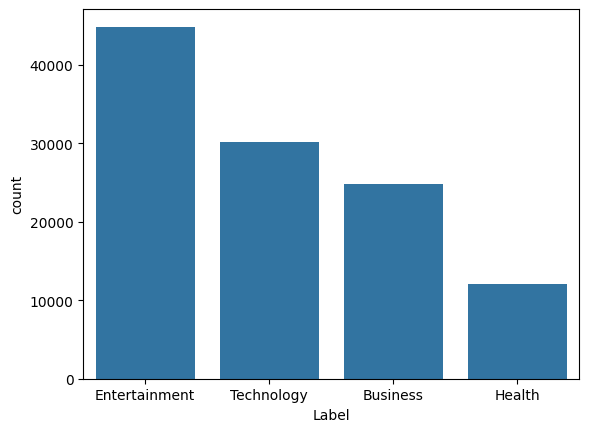

In [ ]:
# explore the dataset
print(train_data.info(), "\n")
print(test_data.info(), "\n")

# let's print some info
print(f"Number of unique labels: {train_data['Label'].nunique()}")
print(f"Unique labels: {train_data['Label'].unique()}")

print(f"\nShape of train dataset: {train_data.shape}")
print(f"Null values on train dataset:\n {train_data.isna().sum()}")
print(f"Duplicate values on train dataset: {train_data.duplicated().sum()}")
print(f"\nShape of test dataset: {test_data.shape}")
print(f"Null values on test dataset:\n {test_data.isna().sum()}")
print(f"Duplicate values on test dataset: {test_data.duplicated().sum()}")
print(f"\nData types of each feature:\n{train_data.dtypes}")
print(" ")

# check the distributions on the train data
print(f"Number of samples in each category:\n{train_data['Label'].value_counts()}")

# plot these distributions
sns.countplot(x='Label', data=train_data)
plt.show()

The distribution of training data across the categories appears to be imbalanced. The Entertainment category has the highest number of samples, followed by Technology, Business, and finally Health, which has the lowest representation. This imbalance might lead to biases in model performance, where the model could perform better on the majority classes (like Entertainment) but struggle with minority classes (like Health). To address this, techniques such as oversampling the minority classes, undersampling the majority classes, or using class weights during training might be necessary to improve overall classification performance.

Now, we generate the feature and label sets for training using the provided training data.

In [ ]:
# define features and labels
train_labels = train_data['Label']
train_data = train_data.drop('Label', axis=1)

# let's look at the first example of the train dataset and its label
print(f"1st sample of the dataset is\n {train_data.iloc[0]}")
print(f"Label: {train_labels[0]}")

# let's see at how some examples
print(f"\nFirst sample's Title: {train_data['Title'][0]}")
print(f"Second sample's Title: {train_data['Title'][1]}")

1st sample of the dataset is
 Id                                                    227464
Title      Netflix is coming to cable boxes, and Amazon i...
Content     if you subscribe to one of three rinky-dink (...
Name: 0, dtype: object
Label: Entertainment

First sample's Title: Netflix is coming to cable boxes, and Amazon is now your grocery overlord
Second sample's Title: Pharrell, Iranian President React to Tehran 'Happy' Arrests


We observed above that in feature set columns of Title and Content are of type object. In machine learning, algorithms require numerical inputs. Therefore, when working with text data, we must convert it into numbers. One common method for this is the Bag of Words (BoW) model.

The Bag of Words (BoW) is a simple and widely used representation of text data in Natural Language Processing (NLP) and Machine Learning. It converts text into numerical feature vectors, enabling its use in machine learning algorithms.

Given a dataset with $m$ samples containing text columns (e.g., Title and Content), the BoW workflow operates as follows: First, it performs tokenization, splitting each text into individual words (tokens). Then, it creates a vocabulary—a list of all unique words across the entire dataset (corpus). Next, it counts the occurrences of each token in each sample (document). Finally, it represents each sample as a numerical vector based on these word counts.

The BoW model ignores the order of words, focusing solely on their frequency, making it a simple and effective approach for text classification tasks.

Example of two text samples:

Sample 1: "Netflix is coming to cable boxes, and Amazon is now your grocery overlord"

Sample 2: "Pharrell, Iranian President React to Tehran 'Happy' Arrests"

The produced Vocabulary is:

["Netflix", "is", "coming", "to", "cable", "boxes", "and", "Amazon", "now", "your", "grocery", "overlord", "Pharrell", "Iranian", "President", "React", "Tehran", "Happy", "Arrests"]

And the final BoW representations for the two samples:

Sample 1: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]

Sample 2: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

(Notice that the word "to" is present in both samples, so it appears only once in the vocabulary. Similarly, the word "is" appears twice in the first sample, so its count in the representation is 2.)

Each vector represents the word frequencies in the respective sample, following the BoW methodology. This numerical representation is now ready for input into machine learning models.

We take into account both 'Title' and 'Content' text feature columns combined for the training.

In [ ]:
# check the shapes of train and test datasets before processing
print(f"\nShape of train dataset: {train_data.shape}")
print(f"Shape of the labels of train dataset: {train_labels.shape}")
print(f"\nShape of test dataset: {test_data.shape}")

# combine 'Title' and 'Content' feature columns into a single feature (one corpus)
train_data['Text'] = train_data['Title'] + ' ' + train_data['Content']
test_data['Text'] = test_data['Title'] + ' ' + test_data['Content']

# define X_train, X_test, y_train
X_train = train_data['Text']
X_test = test_data['Text']

# initialize vectorizer and fit it on the combined corpus
vectorizer = CountVectorizer(stop_words = 'english', max_features=10000) # # use built-in stop words removal and set the vocabulary size to 10k
X_train_bow = vectorizer.fit_transform(X_train) # fit on training set
X_test_bow = vectorizer.transform(X_test) # transform test set

# check the shape of the combined corpus
print(f"\nNumber of unique tokens in our vocabulary: {len(vectorizer.vocabulary_)}")

# check the current shapes of the train and test datasets
print(f"Shape of X_train_bow: {X_train_bow.shape}")
print(f"Shape of X_test_bow: {X_test_bow.shape}")


Shape of train dataset: (111795, 3)
Shape of the labels of train dataset: (111795,)

Shape of test dataset: (47912, 3)

Number of unique tokens in our vocabulary: 10000
Shape of X_train_bow: (111795, 10000)
Shape of X_test_bow: (47912, 10000)


Let's see now the most common words in our vocabulary in a Word Cloud plot.

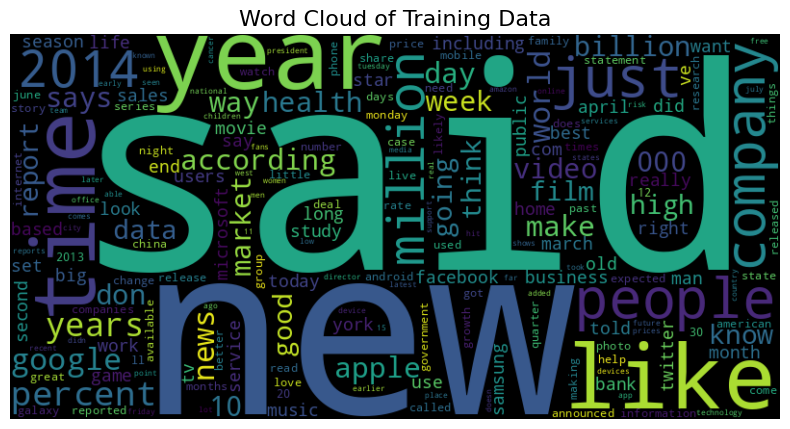

In [ ]:
# generate and plot a word cloud from a CountVectorizer and its transformed data

# 1. extract feature names and their frequencies
feature_names = vectorizer.get_feature_names_out()  # get feature names (words)
word_counts = X_train_bow.sum(axis=0).A1  # sum word occurrences across all documents and convert to array(A1 for flatten X_train_bow sparse matrix)

# 2. create a dictionary of words and their counts
word_freq = {word: count for word, count in zip(feature_names, word_counts)}

# 3. generate the word cloud
wordcloud = WordCloud(width=800, height=400, colormap='viridis',background_color='black').generate_from_frequencies(word_freq)

# 4. plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # turn off axis
plt.title("Word Cloud of Training Data", fontsize=16)
plt.show()

We also convert the labels to a numerical format.

In [ ]:
# convert labels to numbers
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels)

# print the mapping between classes and their encoded values
class_mapping = dict(enumerate(label_encoder.classes_))
print("Class Mapping:", class_mapping)

Class Mapping: {0: 'Business', 1: 'Entertainment', 2: 'Health', 3: 'Technology'}


## 2. Apply Cross-Validation and Hyperparameter Tuning for both SVM and Random Forest models.

We will use a $5$-Fold Cross Validation technique for the training. Cross-validation is a technique to evaluate a model's performance by splitting the dataset into multiple subsets (folds). The model is trained on $k - 1$  folds and tested on the remaining fold. This process repeats for each fold, ensuring every subset is used for testing exactly once. The final performance is the average of all folds, providing a reliable estimate of how well the model generalizes to unseen data.

In [ ]:
# function to plot accuracies per fold
def plot_cross_val_results(svm_scores, rf_scores):
  """ Plots accuracy bars per plot for both svm and rf classifiers. """
  folds = [f'Fold {i+1}' for i in range(5)]
  fig, ax = plt.subplots(1, 2, figsize=(14, 6))

  # SVM results
  ax[0].bar(folds, svm_scores, color='blue', label='SVM')
  ax[0].set_title('SVM Cross-Validation Results')
  ax[0].set_ylabel('Accuracy')
  ax[0].set_ylim(0, 1)
  ax[0].set_xlabel('Folds')
  ax[0].grid(axis='y', linestyle='--')

  # Random Forest results
  ax[1].bar(folds, rf_scores, color='green', label='Random Forest')
  ax[1].set_title('Random Forest Cross-Validation Results')
  #ax[1].set_ylabel('Accuracy')
  ax[1].set_ylim(0, 1)
  ax[1].set_xlabel('Folds')
  ax[1].grid(axis='y', linestyle='--')

  plt.suptitle('Comparison of SVM and Random Forest Cross-Validation Results of best Configurations', fontsize=16)
  plt.grid(True)
  plt.tight_layout()
  plt.show()

# function to plot accuracies fluctuation through folds
def plot_line_comparison(svm_scores, rf_scores):
    folds = [f'Fold {i+1}' for i in range(5)]

    plt.figure(figsize=(14, 6))
    plt.plot(folds, svm_scores, marker='o', label='SVM', color='blue', linestyle='--')
    plt.plot(folds, rf_scores, marker='o', label='Random Forest', color='green', linestyle='--')
    plt.title('Lines Plot of SVM and Random Forest Cross-Validation Accuracies of best Configurations')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.xlabel('Folds')
    plt.grid(linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

With everything prepared, we train Support Vector Machines (SVM) and Random Forest models using 5-Fold Cross-Validation. Additionally, we perform hyperparameter tuning to optimize the models and achieve the best possible performance. We first train them on a smaller subset of the whole dataset to get an idea of which hyperparameters might work well. We will use the scikit's train_test_split to randomly shuffle and select 30% of the data, ensuring the class distribution is preserved using stratified sampling, with a fixed random_state for reproducibility.

In [ ]:
# select a 30% subset of the data for cross-validation and hyperparameter tuning
X_train_subset, _, y_train_subset, _ = train_test_split(X_train_bow, y_train, test_size=0.7, stratify=y_train, random_state=42)

# verify the sizes of the subset
print(f"Shape of X_train_subset: {X_train_subset.shape}")
print(f"Shape of y_train_subset: {y_train_subset.shape}")

Shape of X_train_subset: (33538, 10000)
Shape of y_train_subset: (33538,)


In [ ]:
# SVM

# 1. define the svm parameter grid
svm_grid = {
    'kernel': ['linear'], # add 'rbf', 'poly'
    'C': [0.1, 1, 10]
    #'gamma': ['scale', 0.1]  also add (for rbf and poly kernels)
}

# 2. initialize the SVM classifier
svm_model = SVC(class_weight='balanced') # handle class imbalance with weights classes

# 3. perform GridSearch for SVM
start_time_svm = time.time()
svm_grid_search = GridSearchCV(svm_model, svm_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# grid search process
svm_grid_search.fit(X_train_subset, y_train_subset)
svm_time = time.time() - start_time_svm

# 4. get all mean accuracies and the best accuracy
svm_scores = svm_grid_search.cv_results_['mean_test_score'] # mean accuracy for each parameter set
svm_accuracy = max(svm_scores)  # best mean accuracy across all parameter sets

# 5. get 5-fold accuracies for the best model/parameters (plotting reasons)
best_svm_model = svm_grid_search.best_estimator_  # retrieve the best model
svm_fold_accuracies = cross_val_score(best_svm_model, X_train_subset, y_train_subset, cv=5)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [ ]:
# Random Forest

# 1. define the random forest parameter grid
rf_grid = {
    'n_estimators': [50, 100, 200]
    #'max_depth': [None, 10, 20],
    #'min_samples_split': [2, 5, 10],
    #'min_samples_leaf': [1, 2, 4],
    #'max_features': ['sqrt', 'log2', None]
}

# 2. initialize the Random Forest classifier
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42) # handle class imbalance with weights, random_state=42 for reproducibility(debugging)

# 3. perform GridSearch for Random Forest
start_time_rf = time.time()
rf_grid_search = GridSearchCV(rf_model, rf_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# grid search process
rf_grid_search.fit(X_train_subset, y_train_subset)
rf_time = time.time() - start_time_rf

# 4. get all mean accuracies and the best accuracy
rf_scores = rf_grid_search.cv_results_['mean_test_score']  # mean accuracy for each parameter set
rf_accuracy = max(rf_scores)  # best mean accuracy across all parameter sets

# 5. get 5-fold accuracies for the best model/parameters (plotting reasons)
best_rf_model = rf_grid_search.best_estimator_  # retrieve the best model
rf_fold_accuracies = cross_val_score(best_rf_model, X_train_subset, y_train_subset, cv=5)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [ ]:
# print the results for both models
print("SVM (BoW) Results:")
print(f"Mean accuracies for each parameter set: {svm_scores}")
print(f"Best Hyperparameters: {svm_grid_search.best_params_}")
print(f"Best 5-fold CV Accuracies for the best model: {svm_fold_accuracies}")
print(f"Best Mean CV Accuracy: {svm_accuracy:.8f}")
print(f"Hyperparameter Tuning Time (15 fits): {svm_time:.8f} seconds")

print("\nRandom Forest (BoW) Results:")
print(f"Mean accuracies for each parameter set: {rf_scores}")
print(f"Best Hyperparameters: {rf_grid_search.best_params_}")
print(f"Best 5-fold CV Accuracies for the best model: {rf_fold_accuracies}")
print(f"Mean CV Accuracy: {rf_accuracy:.8f}")
print(f"Hyperparameter Tuning Time (15 fits): {rf_time:.8f} seconds")

SVM (BoW) Results:
Mean accuracies for each parameter set: [0.94278138 0.93753359 0.93729508]
Best Hyperparameters: {'C': 0.1, 'kernel': 'linear'}
Best 5-fold CV Accuracies for the best model: [0.94260584 0.94305307 0.94081694 0.94408827 0.94334278]
Best Mean CV Accuracy: 0.94278138
Hyperparameter Tuning Time (15 fits): 614.52304626 seconds

Random Forest (BoW) Results:
Mean accuracies for each parameter set: [0.91824218 0.92202891 0.923311  ]
Best Hyperparameters: {'n_estimators': 200}
Best 5-fold CV Accuracies for the best model: [0.91860465 0.92590936 0.92113894 0.92962576 0.92127628]
Mean CV Accuracy: 0.92331100
Hyperparameter Tuning Time (15 fits): 391.10768414 seconds


Let's now make some plots regarding the results.

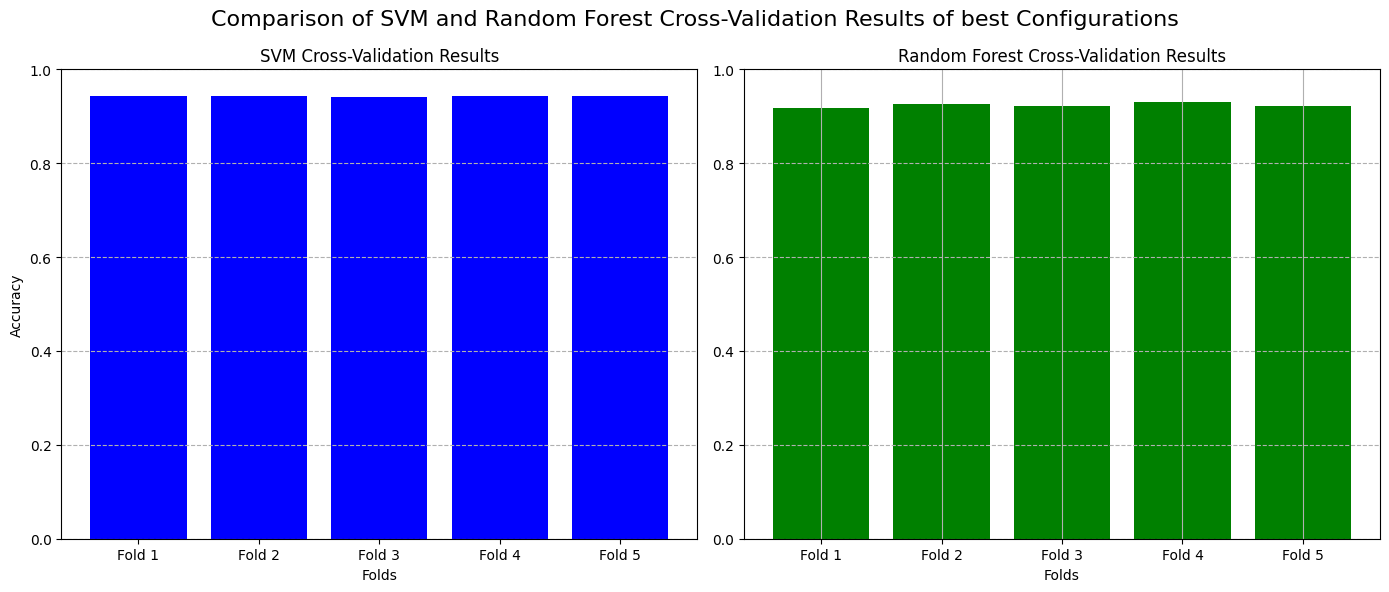

In [ ]:
# plot the results for both classifiers using a bar chart
plot_cross_val_results(svm_fold_accuracies, rf_fold_accuracies)

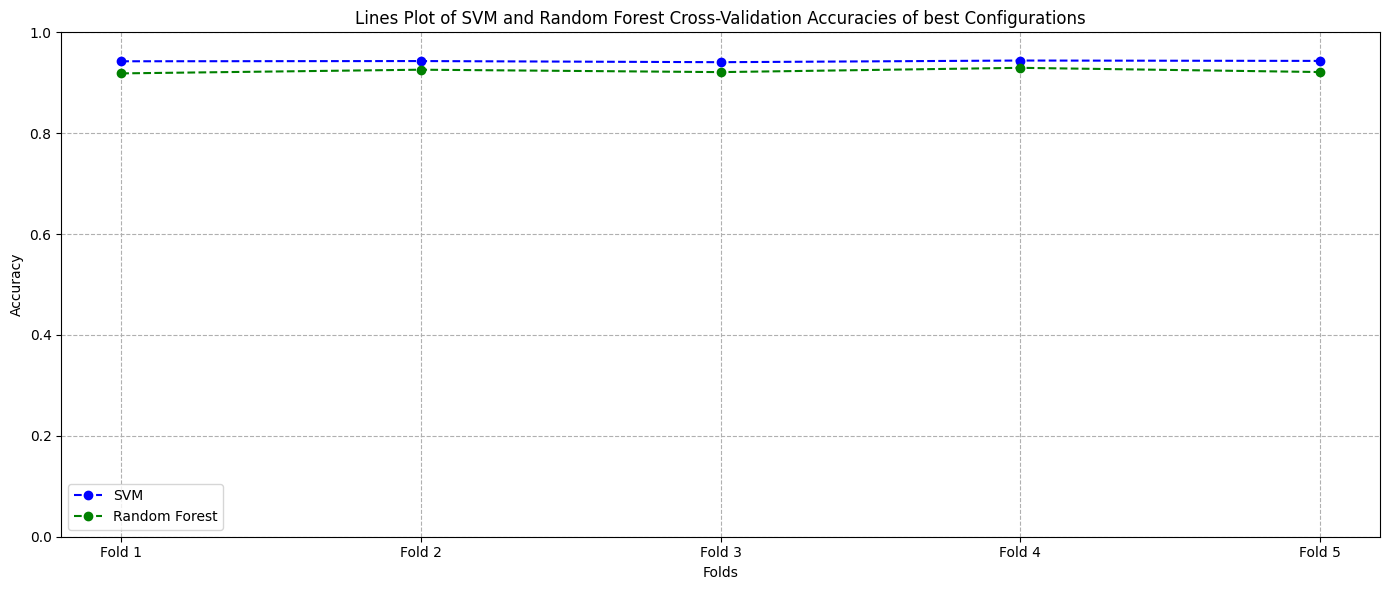

In [ ]:
# plot a line chart
plot_line_comparison(svm_fold_accuracies, rf_fold_accuracies)

The results indicate that SVM with the "linear" kernel achieved a slightly higher mean cross-validation accuracy of 94.27% compared to Random Forest, which achieved 92.33%. The individual fold accuracies for SVM are consistent across all folds, demonstrating robust performance. Random Forest, while slightly less accurate, also shows stable and consistent results across folds without significant variations. In terms of computational efficiency, Random Forest completed hyperparameter tuning in 391 seconds, significantly faster than SVM, which took 614 seconds. Overall, SVM delivers better accuracy, while Random Forest provides a competitive and efficient alternative with stable performance.

The final step is to train this best model (SVM) on the entire training dataset and then make predictions on the test set.

## 3. Train the best model, make predictions and save the results.

In [ ]:
# train the best model on the entire train dataset
best_model = best_svm_model if svm_accuracy > rf_accuracy else best_rf_model
print(f"Best Model: {best_model}")
start_time = time.time()
best_model.fit(X_train_bow, y_train)
best_model_time = time.time() - start_time
print(f"Best Model Training Time: {best_model_time:.2f} seconds")

Best Model: SVC(C=0.1, class_weight='balanced', kernel='linear')
Best Model Training Time: 6237.45 seconds


In [ ]:
# make predictions on the test set
predictions = best_model.predict(X_test_bow)

# convert the predictions back to their originl format
predictions = label_encoder.inverse_transform(predictions)

# check the lengths of X_test and predictions (must be the same)
print(f"Shape of X_test: {X_test_bow.shape}")
print(f"Shape of predictions: {predictions.shape}")

Shape of X_test: (47912, 10000)
Shape of predictions: (47912,)


In [ ]:
# create submission file
submission = pd.DataFrame({'Id': test_data['Id'], 'Predicted': predictions})
submission.to_csv('testSet_categories.csv', index=False)
print("Submission file created successfully.")

Submission file created successfully.


## 4. Try a simple Neural Network model.

Having tried SVM and Random Forest, let's try a simple Neural Network to compare with the above performances.

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# one-hot encode the labels
y_train_nn = to_categorical(y_train, num_classes=4)

# split the dataset into training and validation sets
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train_bow.toarray(), y_train_nn, test_size=0.2, random_state=42)

# define the NN model
def create_nn_model(input_dim, num_classes):
  """ Creates an optimized feedforward neural network for multi-class classification. """
  model = Sequential([
      Input(shape=(input_dim,)),  # explicit Input layer
      Dense(256, activation='relu'),  # first hidden layer
      BatchNormalization(),  # normalize inputs for faster convergence
      Dropout(0.3),  # dropout regularization

      Dense(128, activation='relu'),  # second hidden layer
      BatchNormalization(),
      Dropout(0.3),

      Dense(64, activation='relu'),  # third hidden layer
      BatchNormalization(),
      Dropout(0.3),

      Dense(num_classes, activation='softmax')  # output layer for multi-class classification
    ])

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

# initialize the model
nn_model = create_nn_model(input_dim=X_train_nn.shape[1], num_classes=4) # inputs of NN are the features (len(vectorizer))

# define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # if the val loss does not improve for 'patience' epochs, we stop training erlier and get the best val accuracy and weights from best achieved training state!
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5) # apply lr scheduler adjusting lr by reducing it by 0.5 if val accuracy does not improve for 'patience' epochs with minimum 'min_lr'

# train the model with optimized settings
start_time_nn = time.time()
history = nn_model.fit(
    X_train_nn, y_train_nn,
    validation_data=(X_val_nn, y_val_nn),
    epochs=50,
    batch_size=64,  # try 32, 128
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
nn_time = time.time() - start_time_nn

# evaluate the model on the validation set
val_predictions = np.argmax(nn_model.predict(X_val_nn), axis=1)  # predicted class indices
y_val_true = np.argmax(y_val_nn, axis=1)  # true class indices
nn_accuracy = accuracy_score(y_val_true, val_predictions)

# print results
print(f"\nNeural Network Accuracy on Validation Set: {nn_accuracy:.2f}")
print(f"Neural Network Training Time: {nn_time:.2f} seconds")

Epoch 1/50
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.8793 - loss: 0.3452 - val_accuracy: 0.9643 - val_loss: 0.1077 - learning_rate: 0.0010
Epoch 2/50
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9687 - loss: 0.0910 - val_accuracy: 0.9657 - val_loss: 0.1015 - learning_rate: 0.0010
Epoch 3/50
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9785 - loss: 0.0602 - val_accuracy: 0.9661 - val_loss: 0.1090 - learning_rate: 0.0010
Epoch 4/50
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9831 - loss: 0.0484 - val_accuracy: 0.9677 - val_loss: 0.1051 - learning_rate: 0.0010
Epoch 5/50
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9856 - loss: 0.0418 - val_accuracy: 0.9665 - val_loss: 0.1124 - learning_rate: 0.0010
Epoch 6/50
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9876 - loss: 0.0355 - val_accuracy: 0.9680 - val_loss: 0.1190 - learning_rate: 0.0010
Epoch 7/50
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9891 - 

We see that we achieved higher accuracy than the previous classifiers, which is evidence of the neural network's ability to capture complex patterns and relationships in the data more effectively than SVM and Random Forest.

# Part 2: Text Classification using Nearest Neighbor Search with and without Locality Sensitive Hashing (LSH).

In this section, we will implement the $k$-NN algorithm with $k = 7$, starting with the brute-force approach. This method involves comparing each document in the test set with every document in the training set using the Jaccard similarity (the ratio of the intersection to the union of their sets). To optimize this process, we will then apply the Locality Sensitive Hashing (LSH) approach. In the LSH method, we first identify candidate pairs of test and training documents that are likely to have a Jaccard similarity above a predefined threshold. We then compute the actual similarity only for these candidate pairs, significantly reducing computational overhead.

In [ ]:
!pip install datasketch
print("Datasketch is installed and ready to use!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 2.2 MB/s eta 0:00:00
Datasketch is installed and ready to use!


In [ ]:
from datasketch import MinHash, MinHashLSH

# parameters
thresholds = [0.8, 0.6, 0.5, 0.3] # try different thresholds
permutations = [16, 32, 64] # try different permutations
K = 7

In [ ]:
# Jaccard similarity function
def jaccard_similarity(set1, set2):
  """ Calculates the Jaccard similarity between two sets. """
  intersection = len(set1.intersection(set2))
  union = len(set1) + len(set2) - intersection
  return intersection / float(union) if union != 0 else 0 # avoid unexpected divisions by 0

# plotting function to compare times
def plot_times():
  """ Plots execution times for both methods. """
  methods = ["Brute-Force", f"LSH (Perm={perm})"]
  times = [brute_force_time, lsh_total_time]

  plt.figure(figsize=(8, 5))
  plt.bar(methods, times, color=["blue", "green"])
  plt.title(f"Execution Time Comparison (Permutations = {perm})")
  plt.ylabel("Time (seconds)")
  plt.grid(True)
  plt.show()

# Plot accuracy
def plot_accuracy():
  """ Plots accuracy for both methods. """
  plt.figure(figsize=(8, 5))
  plt.bar(["Correct Fraction"], [correct_fraction], color="orange")
  plt.title(f"Accuracy of LSH vs Brute-Force (Perm={perm})")
  plt.ylabel("Fraction of True K-Nearest Neighbors Found")
  plt.ylim(0, 1)
  plt.grid(True)
  plt.show()

## $k$-NN with Brute-Force and LSH methods.


Our dataset consists of samples, where each sample is represented by tokens (words) and their corresponding frequencies. To calculate the similarity between samples using the Jaccard similarity function, we first transform the train and test datasets into a set-based format. In this representation, each sample is converted into a set of token indices, where each index corresponds to a token present in the sample.

This transformation allows the Jaccard similarity function to directly compute the overlap between sets, as it is designed to operate on set representations. The Jaccard similarity measures the size of the intersection divided by the size of the union of two sets, providing a score between 0 (no overlap) and 1 (complete overlap).

The conversion is implemented as follows:

~~~
test_sets = [set(row.indices) for row in X_test_bow]
train_sets = [set(row.indices) for row in X_train_bow]
~~~

The resulting test_sets and train_sets are then passed to the custom jaccard_similarity function, which computes the similarity between any pair of samples by evaluating the overlap between their respective sets. This approach ensures a straightforward and efficient computation of Jaccard similarity for the dataset.


In [ ]:
# extract indices of each row and transform them into sets (ready for Jaccard similarity function)
test_sets = [set(row.indices) for row in X_test_bow]
train_sets = [set(row.indices) for row in X_train_bow]

In [ ]:
# Brute-force method

# loop over all test and train text samples
print("Starting brute-force method without batches...")
start_time = time.time()  # start timer
brute_force_results = []  # storage list for the brute-force method results

# iterate over each test set
for test_set in tqdm(test_sets, desc="Processing test samples"):

  similarities = []  # Storage list for similarities with all train sets

  # process each test set with all train sets
  for train_set in train_sets:

    # calculate and store the Jaccard similarity for the current pair
    simil = jaccard_similarity(test_set, train_set)
    similarities.append(simil)

  # find the top K similar indices
  top_k_indices = np.argsort(similarities)[-K:][::-1]  # sort and take the K most similar indices
  brute_force_results.append(top_k_indices)  # store the results for the current test sample

# calculate and print the total processing time
brute_force_time = time.time() - start_time
print(f"Training finished in {brute_force_time:.2f} seconds!")

Starting brute-force method without batches...


Processing test samples: 100%|██████████| 47912/47912 [6:38:08<00:00,  2.01it/s]

Training finished in 23888.82 seconds!


As we see, training a $k$-NN model with the brute-force method took approximately 7 hours due to comparing each test sample with all training samples. While this achieved the highest accuracy, it was extremely time-consuming and required significant computational resources on a 32GB RAM system.

In [ ]:
# save all the brute-force reults to csv file
brute_force_results_df = pd.DataFrame(brute_force_results)
brute_force_results_df.to_csv('brute_force_results.csv', index=False)
print("Brute-Force results saved to csv file.")

Brute-Force results saved to csv file.


In [ ]:
# print some (5) first results
print(f"Brute-Force method results for the first 5 test samples:\n {brute_force_results[:5]}")

Brute-Force method results for the first 5 test samples:
 [array([ 92805,   7525, 111794,  26174,  49595,  20658,   3517]), array([76739, 90631, 35978, 93929, 54724, 27273, 82252]), array([ 61614,  44049,  23789, 108137,  31130,  26247,  60918]), array([ 22913, 100258,  61736,  49379,   5542, 102225,  13519]), array([ 27772,  45826,  41955,  22671,  98342, 102827,  66158])]


Each test sample (1D array) in the results represents the $k$-nearest neighbors from the indices in the training set. The indices correspond to the positions of training samples in the X_train_bow_binary_full array. These indices indicate the training documents that are most similar to the respective test sample.

Each $k$-value in the arrays represents the index of a training sample that is among the top $k$-most similar samples to the corresponding test sample, based on the Jaccard similarity measure.

For example, if the output for a test sample is:
~~~
array([92805, 7525, 111794, 26174, 49595, 20658, 3517])
~~~
This means the training sample at index 92805 has the highest Jaccard similarity to the test sample, the training sample at index 7525 has the second-highest similarity and 7th most similar training sample at index 3517.

The brute-force method achieves 100% accuracy because it exhaustively computes the Jaccard similarity between every pair of test and train samples, ensuring the exact
$k$-nearest neighbors are identified. This serves as the benchmark for comparison with approximate methods like LSH, which prioritize efficiency and scalability by sacrificing some accuracy for significantly faster query times.

In the LSH method, we first compute MinHash signatures for each training sample to create compact representations of the data. A MinHash signature is a fixed-length vector (e.g., length 16, 32, 64, or 128) that approximates the Jaccard similarity between sets and determined by the given permutations. It captures the essence of the set, ensuring that similar sets have similar MinHash signatures. A larger number of hash functions increases the accuracy of the approximation but also raises the computational cost, creating a trade-off between accuracy and efficiency.

These MinHash signatures are inserted into an LSH index, which groups similar signatures into the same buckets based on a predefined similarity threshold. This process avoids exhaustive pairwise comparisons, significantly improving computational efficiency.

For each test sample, we compute its MinHash signature and query the LSH index to retrieve candidate neighbors by comparing the test signature with those in the same bucket. Using precomputed sets, we calculate the exact Jaccard similarity between the test sample and its candidates, sort the results, and select the top $K$ most similar documents. Finally, we compare these results with brute-force $K$-NN to evaluate the accuracy and efficiency of the LSH method.

Starting with a high threshold like 0.9 and permutations of $16, 32,$ or $64$ can result in too few bands ($b < 2$), which makes the LSH configuration invalid. In LSH, a band is a subset of rows from the MinHash signature matrix. Items with similar rows in a band are hashed into the same bucket, and items in the same bucket are considered candidates for similarity. Lowering the threshold (e.g., to $0.8, 0.5, ...$) increases the number of bands, allowing the MinHashLSH to divide the permutations properly, create enough buckets, and effectively identify similar items. That is why we start trying with a lower than 0.9 threshold.

In [ ]:
# LSH method

results = []  # storage list for the LSH method results for all thresholds

print("Starting LSH method...")
for threshold in thresholds:
  # iterate through all permutation values
  for perm in permutations:
    lsh_build_start = time.time()  # start build timer

    # 1. create MinHash objects for the training samples
    train_minhashes = [MinHash(num_perm=perm) for _ in train_sets]
    for idx, (train_set, minhash) in enumerate(zip(train_sets, train_minhashes)):
      for token in train_set:
        minhash.update(str(token).encode('utf8'))  # update MinHash with token values

    # 2. build LSH index
    lsh = MinHashLSH(threshold=threshold, num_perm=perm)  # initialize the LSH index object
    count = 0  # count the items inserted in the LSH index
    for idx, minhash in enumerate(train_minhashes):
      lsh.insert(f"train_{idx}", minhash)  # insert MinHash signatures into the LSH index
      count += 1
    lsh_build_time = time.time() - lsh_build_start  # calculate total build time

    # 3. query time
    lsh_results = {}  # storage dictionary for LSH results for all test samples
    lsh_query_start = time.time()

    # process each test sample individually
    for i, test_set in enumerate(tqdm(test_sets, desc="Processing test samples")):
      # create MinHash for the current test sample
      query_minhash = MinHash(num_perm=perm)
      for token in test_set:
        query_minhash.update(str(token).encode('utf8'))  # update MinHash with token values

      # 4. query LSH to find candidate neighbors
      candidates = lsh.query(query_minhash)  # get candidate neighbors from LSH
      similarities = []
      candidate_indices = []
      for candidate in candidates:
        train_index = int(candidate.split("_")[1])  # extract train index from candidate ID
        simil = jaccard_similarity(test_set, train_sets[train_index])  # compute Jaccard similarity
        similarities.append(simil)
        candidate_indices.append(train_index)

      # 5. sort and select top K results
      top_k_indices = [candidate_indices[idx] for idx in np.argsort(similarities)[-K:][::-1]]  # Sort descending
      lsh_results[i] = top_k_indices  # store top K indices of similarities for the current test sample

    lsh_query_time = time.time() - lsh_query_start  # calculate total query time

    # 6. calculate total time: build + query
    lsh_total_time = lsh_build_time + lsh_query_time

    # 7. fraction of true K-most similar docs (brute-force/LSH)
    correct_count = 0
    total_count = len(brute_force_results) * K  # total number of possible comparisons/matches (K per test sample)

    # compare brute-force and LSH results for each test sample
    for brute, lsh in zip(brute_force_results, lsh_results.values()):
      correct_count += len(set(brute).intersection(set(lsh)))  # count overlapping results

      # calculate the fraction of correct matches: total correct matches / total possible matches
      correct_fraction = correct_count / total_count

    # store results
    results.append({
        'threshold': threshold,
        'permutations': perm,
        'build_time': lsh_build_time,
        'query_time': lsh_query_time,
        'total_time': lsh_total_time,
        'correct_fraction': correct_fraction,
        'lsh_results': lsh_results
    })

print("Training finished!")

Starting LSH method...


Processing test samples: 100%|██████████| 47912/47912 [02:42<00:00, 294.38it/s]

Training finished!


In [ ]:
# save the results to another csv file
lsh_results_df = pd.DataFrame(results)
lsh_results_df.to_csv('lsh_results.csv', index=False)
print("LSH results saved to csv file.")

LSH results saved to csv file.


In [ ]:
# print all results
print("\nFinal Results:")
for result in results:
  print(f"Threshold: {result['threshold']}, Permutations: {result['permutations']}")
  print(f"Build Time: {result['build_time']:.4f} seconds")
  print(f"Query Time: {result['query_time']:.4f} seconds")
  print(f"Total Time: {result['total_time']:.4f} seconds")
  print(f"Fraction of True K-Most Similar Documents: {result['correct_fraction']:.4f}\n")
  # print the top K vectors for each test example
  #print(f"\nTop K vectors for each test example for threshold {result['threshold']} and permutations {result['permutations']}:")
  #for test_idx, top_k in result['lsh_results'].items():
    #print(f"Test Example {test_idx}: {top_k}")


Final Results:
Threshold: 0.8, Permutations: 16
Build Time: 189.0188 seconds
Query Time: 87.6272 seconds
Total Time: 276.6460 seconds
Fraction of True K-Most Similar Documents: 0.0284

Threshold: 0.8, Permutations: 32
Build Time: 201.7906 seconds
Query Time: 92.2695 seconds
Total Time: 294.0601 seconds
Fraction of True K-Most Similar Documents: 0.0287

Threshold: 0.8, Permutations: 64
Build Time: 230.7110 seconds
Query Time: 101.9420 seconds
Total Time: 332.6530 seconds
Fraction of True K-Most Similar Documents: 0.0315

Threshold: 0.6, Permutations: 16
Build Time: 186.9350 seconds
Query Time: 86.9842 seconds
Total Time: 273.9192 seconds
Fraction of True K-Most Similar Documents: 0.0627

Threshold: 0.6, Permutations: 32
Build Time: 201.7195 seconds
Query Time: 92.3166 seconds
Total Time: 294.0361 seconds
Fraction of True K-Most Similar Documents: 0.0560

Threshold: 0.6, Permutations: 64
Build Time: 227.7005 seconds
Query Time: 103.9024 seconds
Total Time: 331.6030 seconds
Fraction of T

We observe that as the threshold decreases, the fraction of true $k$-most similar documents increases because a lower threshold allows more candidate neighbors to be retrieved, improving the detection rate. Similarly, increasing the number of permutations improves the MinHash representations, enhancing the accuracy of similarity detection and leading to a higher fraction. These trends highlight the trade-off between computation time and accuracy, with lower thresholds and higher permutations improving accuracy at the cost of increased build and query times.

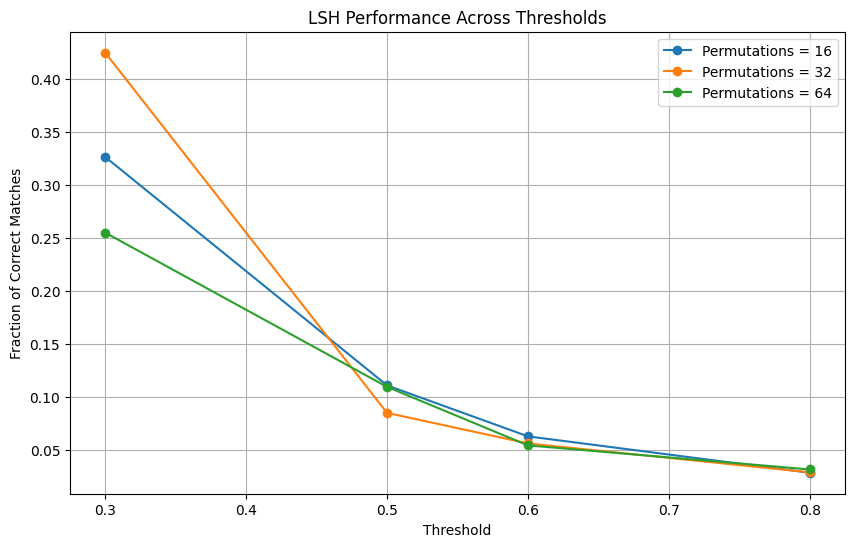

In [ ]:
# plot LSH performance vs. threshold for all ppermutations
fig, ax = plt.subplots(figsize=(10, 6))  # figure size

for perm in permutations:
  x = thresholds
  y = [r['correct_fraction'] for r in results if r['permutations'] == perm]
  ax.plot(x, y, marker='o', label=f"Permutations = {perm}")

ax.set_title("LSH Performance Across Thresholds")
ax.set_xlabel("Threshold")
ax.set_ylabel("Fraction of Correct Matches")
ax.legend()
plt.grid(True)
plt.show()

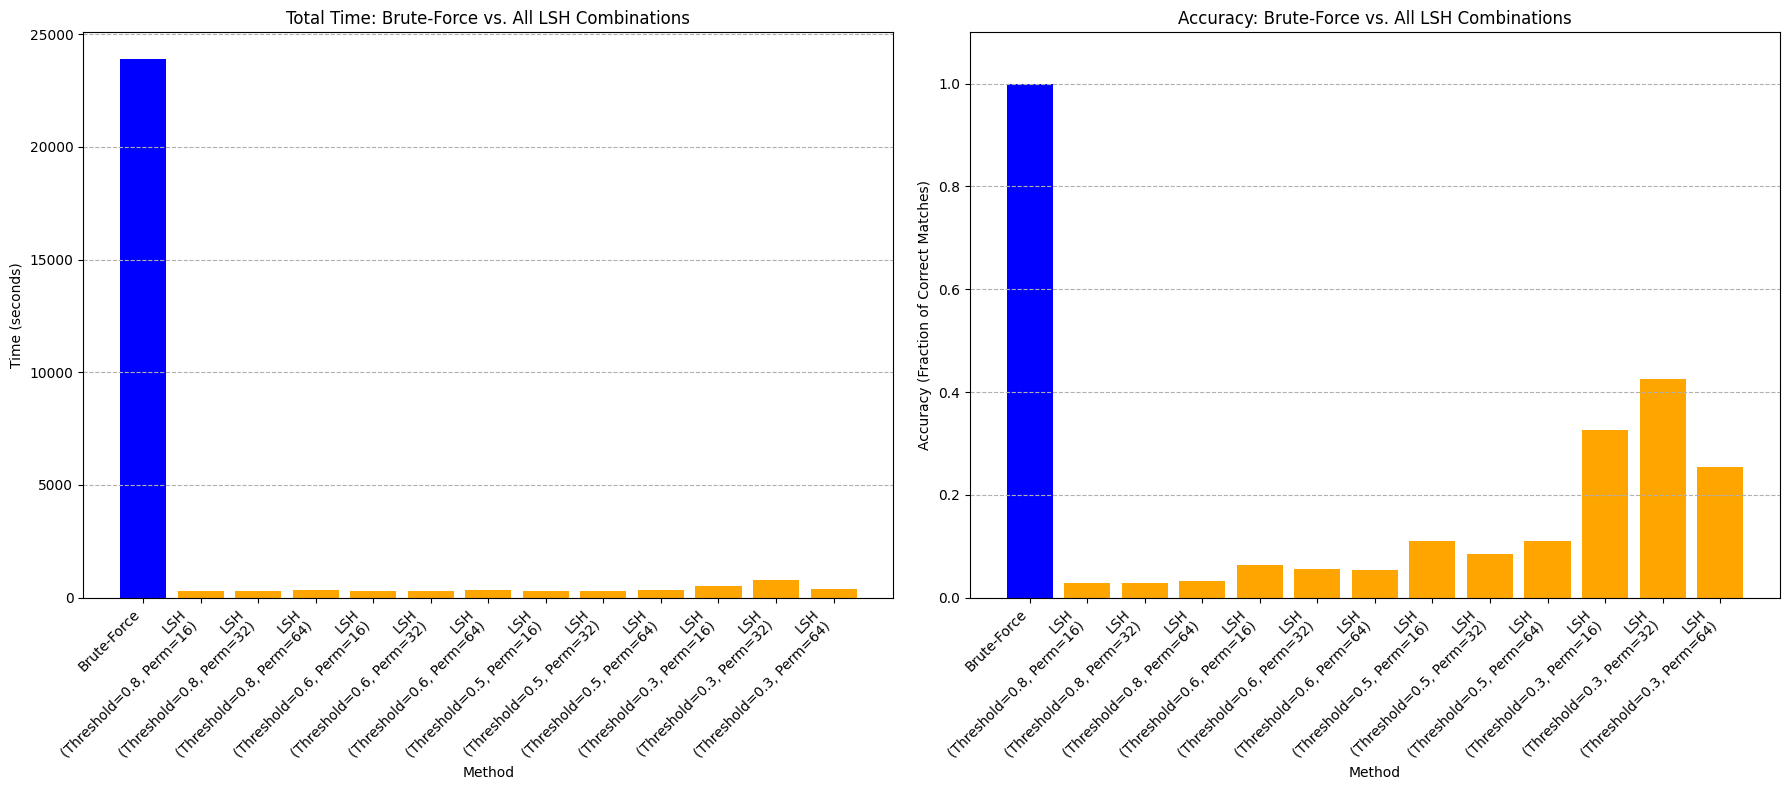

In [ ]:
brute_force_accuracy = 1.0  # brute-force is always 100% accurate

# prepare data for plotting
methods = []
times = []
accuracies = []

# add all combinations of thresholds and permutations to the methods, times, and accuracies lists
for threshold in thresholds:
  for perm in permutations:
    matching_result = next((r for r in results if r['threshold'] == threshold and r['permutations'] == perm), None)
    if matching_result:
      methods.append(f"LSH\n(Threshold={threshold}, Perm={perm})")
      times.append(matching_result['total_time'])
      accuracies.append(matching_result['correct_fraction'])

# add brute force baseline
methods.insert(0, "Brute-Force")
times.insert(0, brute_force_time)
accuracies.insert(0, brute_force_accuracy)

# create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # 1 row, 2 columns

# plot total times in the first subplot
axes[0].bar(methods, times, color=['blue'] + ['orange'] * len(results))
axes[0].set_title("Total Time: Brute-Force vs. All LSH Combinations")
axes[0].set_ylabel("Time (seconds)")
axes[0].set_xlabel("Method")
axes[0].grid(axis='y', linestyle='--')
axes[0].set_xticks(range(len(methods)))
axes[0].set_xticklabels(methods, rotation=45, ha='right')  # rotate x-axis labels

# plot accuracies in the second subplot
axes[1].bar(methods, accuracies, color=['blue'] + ['orange'] * len(results))
axes[1].set_title("Accuracy: Brute-Force vs. All LSH Combinations")
axes[1].set_ylabel("Accuracy (Fraction of Correct Matches)")
axes[1].set_xlabel("Method")
axes[1].grid(axis='y', linestyle='--')
axes[1].set_ylim(0, 1.1)
axes[1].set_xticks(range(len(methods)))
axes[1].set_xticklabels(methods, rotation=45, ha='right')  # rotate x-axis labels

# display the plots
plt.tight_layout()
plt.show()

## Experimenting with batch size.

In this section, we experiment with different batch sizes (500 and 32) to evaluate their impact on performance and identify potential improvements.

### $k$-NN with Brute-Force and LSH methods with batch size = 500.

In [ ]:
# set the batch_size
batch_size = 500

In [ ]:
# brute-force method

# loop over all test and train text samples
print("Starting brute-force method...")
start_time = time.time() #start timer
brute_force_results = [] # storage list for the brute-force method results

for start_idx in tqdm(range(0, len(test_sets), batch_size), desc="Processing test samples"):

  # determine the end index for the current batch
  end_idx = min(start_idx + batch_size, len(test_sets))
  batch_test_sets = test_sets[start_idx:end_idx]

  batch_results = [] # storage list for batches: all of its elements -> brute_force_results list

  # iterate over all test set in batches
  for test_set in batch_test_sets:

    # process each test set with all train sets
    similarities = []

    for train_set in train_sets:

      # calculate and store the Jaccard similarity for the current pair
      simil = jaccard_similarity(test_set, train_set)
      similarities.append(simil)

    top_k_indices = np.argsort(similarities)[-K:][::-1] # sort all pairs of similarities in asc order (X_test_bow.shape[0], X_train_bow.shape[0]), and only take the K top similar indices(starting from the end)
    batch_results.append(top_k_indices) # and store them in the list

  brute_force_results.extend(batch_results) # and store the batch results in the final results list
brute_force_time = time.time() - start_time # calculate and print the total time
print(f"Training finished in {brute_force_time:.2f} seconds!")

Starting brute-force method...


Processing test samples: 100%|██████████| 96/96 [6:53:04<00:00, 258.17s/it]

Training finished in 24784.01 seconds!
Training finished in 24784.01 seconds!


In [ ]:
# print some (5) first results
print(f"Brute-Force method results for the first 5 test samples:\n {brute_force_results[:5]}")

Brute-Force method results for the first 5 test samples:
 [array([ 92805,   7525, 111794,  26174,  49595,  20658,   3517]), array([76739, 90631, 35978, 93929, 54724, 27273, 82252]), array([ 61614,  44049,  23789, 108137,  31130,  26247,  60918]), array([ 22913, 100258,  61736,  49379,   5542, 102225,  13519]), array([ 27772,  45826,  41955,  22671,  98342, 102827,  66158])]


In [ ]:
# LSH method

results = [] # storage list for the LSH method results for all thresholds

print("Starting LSH method...")
for threshold in thresholds:

# iterate through all permutation values
  for perm in permutations:
    lsh_build_start = time.time() # start build timer

    # 1. create MinHash objects for the training samples
    train_minhashes = [MinHash(num_perm=perm) for _ in train_sets]
    for idx, (train_set, minhash) in enumerate(zip(train_sets, train_minhashes)): # remember train_sets is binary
      #print(f"Train Set {idx}: {train_set}") # check train set
      for token in train_set:
        minhash.update(str(token).encode('utf8')) # update MinHash with token values
      #print(f"Updated Train MinHash {idx}: {minhash.hashvalues}")

    # 2. build LSH index
    lsh = MinHashLSH(threshold=threshold, num_perm=perm) # initialize the LSH index object with threshold and permutaion
    #print(f"Type of lsh: {type(lsh)}")
    count = 0 # count the items inserted in LSH index
    for idx, minhash in enumerate(train_minhashes):
      lsh.insert(f"train_{idx}", minhash) # insert MinHash signatures into the LSH index
      #print(f"Inserted train_{idx} into LSH")
      count += 1
    lsh_build_time = time.time() - lsh_build_start # calculate total build time

    # print LSH index size
    #print(f"\nLSH Index Size for Permutations = {perm}: {count}")

    # 3. query time
    lsh_results = {} # storage dictionary for LSH results for all test samples
    lsh_query_start = time.time()


    # query with with batch processing
    for start_idx in tqdm(range(0, len(test_sets), batch_size), desc="Processing test samples"):
      end_idx = min(start_idx + batch_size, len(test_sets))
      batch_test_sets = test_sets[start_idx:end_idx]

      for i, test_set in enumerate(batch_test_sets, start=start_idx): # this came after error here(start=start_idx): ensures the correct indexing
        query_minhash = MinHash(num_perm=perm) # create MinHash for the current test sample
        for token in test_set:
          query_minhash.update(str(token).encode('utf8'))  # update MinHash indices where token is present

        # 4. query LSH to find candidate neighbors
        candidates = lsh.query(query_minhash) # get candidate neighbors from LSH
        similarities = []
        candidate_indices = []
        for candidate in candidates:
          train_index = int(candidate.split("_")[1]) # extract train index from candidate ID
          simil = jaccard_similarity(test_set, train_sets[train_index]) # compute JJaccard similarity
          similarities.append(simil)
          candidate_indices.append(train_index) # store candidate indices

        # 5. sort and select top K results
        top_k_indices = [candidate_indices[idx] for idx in np.argsort(similarities)[-K:][::-1]] # sort in descending order
        lsh_results[i] = top_k_indices # store top K indices of similarities for the current test sample
    lsh_query_time = time.time() - lsh_query_start # calculate total query time

    # 6. calculate total time: build + query
    lsh_total_time = lsh_build_time + lsh_query_time

    # 7. fraction of true K-most similar docs(brute-force/lsh)
    correct_count = 0
    total_count = len(brute_force_results) * K  # total number of possible comparisons/matches (K per test sample)

    # loop over brute-force and LSH results for each test sample and compare
    for brute, lsh in zip(brute_force_results, lsh_results.values()):
      # and count how many of the K nearest neighbors match between the methods
      correct_count += len(set(brute).intersection(set(lsh)))

    # calculate the fraction of correct matches: total correct matches / total possible matches
    correct_fraction = correct_count / total_count

    # store results
    results.append({'threshold': threshold,
                    'permutations': perm,
                    'build_time': lsh_build_time,
                    'query_time': lsh_query_time,
                    'total_time': lsh_total_time,
                    'correct_fraction': correct_fraction,
                    'lsh_results': lsh_results
                    })

print("Training finished!")

Starting LSH method...


Processing test samples: 100%|██████████| 96/96 [02:54<00:00,  1.82s/it]

Training finished!


In [ ]:
# print all results
print("\nFinal Results:")
for result in results:
  print(f"Threshold: {result['threshold']}, Permutations: {result['permutations']}")
  print(f"Build Time: {result['build_time']:.4f} seconds")
  print(f"Query Time: {result['query_time']:.4f} seconds")
  print(f"Total Time: {result['total_time']:.4f} seconds")
  print(f"Fraction of True K-Most Similar Documents: {result['correct_fraction']:.4f}")
  # print the top K vectors for each test example
  #print(f"\nTop K vectors for each test example for threshold {result['threshold']} and permutations {result['permutations']}:")
  #for test_idx, top_k in result['lsh_results'].items():
    #print(f"Test Example {test_idx}: {top_k}")
  print()


Final Results:
Threshold: 0.8, Permutations: 16
Build Time: 225.8105 seconds
Query Time: 102.0551 seconds
Total Time: 327.8655 seconds
Fraction of True K-Most Similar Documents: 0.0284

Threshold: 0.8, Permutations: 32
Build Time: 240.2636 seconds
Query Time: 108.9287 seconds
Total Time: 349.1922 seconds
Fraction of True K-Most Similar Documents: 0.0287

Threshold: 0.8, Permutations: 64
Build Time: 272.3997 seconds
Query Time: 121.2127 seconds
Total Time: 393.6124 seconds
Fraction of True K-Most Similar Documents: 0.0314

Threshold: 0.6, Permutations: 16
Build Time: 225.3436 seconds
Query Time: 102.3391 seconds
Total Time: 327.6827 seconds
Fraction of True K-Most Similar Documents: 0.0627

Threshold: 0.6, Permutations: 32
Build Time: 243.1708 seconds
Query Time: 108.1945 seconds
Total Time: 351.3653 seconds
Fraction of True K-Most Similar Documents: 0.0560

Threshold: 0.6, Permutations: 64
Build Time: 273.5221 seconds
Query Time: 121.3173 seconds
Total Time: 394.8394 seconds
Fraction 

### $k$-NN with Brute-Force and LSH methods with batch size = 32.

In [ ]:
# set the batch_size
batch_size = 32

In [ ]:
# brute-force method

# extract indices of each row and transform it to a set (ready for jaccard similarity function)
test_sets = [set(row.indices) for row in X_test_bow]
train_sets = [set(row.indices) for row in X_train_bow]

# loop over all test and train text samples
print("Starting brute-force method...")
start_time = time.time() #start timer
brute_force_results = [] # storage list for the brute-force method results

for start_idx in tqdm(range(0, len(test_sets), batch_size), desc="Processing test samples"):

  # determine the end index for the current batch
  end_idx = min(start_idx + batch_size, len(test_sets))
  batch_test_sets = test_sets[start_idx:end_idx]

  batch_results = [] # storage list for batches: all of its elements -> brute_force_results list

  # iterate over all test set in batches
  for test_set in batch_test_sets:

    # process each test set with all train sets
    similarities = []

    for train_set in train_sets:

      # calculate and store the Jaccard similarity for the current pair
      simil = jaccard_similarity(test_set, train_set)
      similarities.append(simil)

    top_k_indices = np.argsort(similarities)[-K:][::-1] # sort all pairs of similarities in asc order (X_test_bow.shape[0], X_train_bow.shape[0]), and only take the K top similar indices(starting from the end)
    batch_results.append(top_k_indices) # and store them in the list

  brute_force_results.extend(batch_results) # and store the batch results in the final results list
brute_force_time = time.time() - start_time # calculate and print the total time
print(f"Training finished in {brute_force_time:.2f} seconds!")

Starting brute-force method...


Processing test samples: 100%|██████████| 1498/1498 [6:35:57<00:00, 15.86s/it]

Training finished in 23757.58 seconds!


In [ ]:
# print some (5) first results
print(f"Brute-Force method results for the first 5 test samples:\n {brute_force_results[:5]}")

Brute-Force method results for the first 5 test samples:
 [array([ 92805,   7525, 111794,  26174,  49595,  20658,   3517]), array([76739, 90631, 35978, 93929, 54724, 27273, 82252]), array([ 61614,  44049,  23789, 108137,  31130,  26247,  60918]), array([ 22913, 100258,  61736,  49379,   5542, 102225,  13519]), array([ 27772,  45826,  41955,  22671,  98342, 102827,  66158])]


In [ ]:
# LSH method

results = [] # storage list for the LSH method results for all thresholds

print("Starting LSH method...")
for threshold in thresholds:

# iterate through all permutation values
  for perm in permutations:
    lsh_build_start = time.time() # start build timer

    # 1. create MinHash objects for the training samples
    train_minhashes = [MinHash(num_perm=perm) for _ in train_sets]
    for idx, (train_set, minhash) in enumerate(zip(train_sets, train_minhashes)): # remember train_sets is binary
      #print(f"Train Set {idx}: {train_set}") # check train set
      for token in train_set:
        minhash.update(str(token).encode('utf8')) # update MinHash with token values
      #print(f"Updated Train MinHash {idx}: {minhash.hashvalues}")

    # 2. build LSH index
    lsh = MinHashLSH(threshold=threshold, num_perm=perm) # initialize the LSH index object with threshold and permutaion
    #print(f"Type of lsh: {type(lsh)}")
    count = 0 # count the items inserted in LSH index
    for idx, minhash in enumerate(train_minhashes):
      lsh.insert(f"train_{idx}", minhash) # insert MinHash signatures into the LSH index
      #print(f"Inserted train_{idx} into LSH")
      count += 1
    lsh_build_time = time.time() - lsh_build_start # calculate total build time

    # print LSH index size
    #print(f"\nLSH Index Size for Permutations = {perm}: {count}")

    # 3. query time
    lsh_results = {} # storage dictionary for LSH results for all test samples
    lsh_query_start = time.time()


    # query with with batch processing
    for start_idx in tqdm(range(0, len(test_sets), batch_size), desc="Processing test samples"):
      end_idx = min(start_idx + batch_size, len(test_sets))
      batch_test_sets = test_sets[start_idx:end_idx]

      for i, test_set in enumerate(batch_test_sets, start=start_idx): # this came after error here(start=start_idx): ensures the correct indexing
        query_minhash = MinHash(num_perm=perm) # create MinHash for the current test sample
        for token in test_set:
          query_minhash.update(str(token).encode('utf8'))  # update MinHash indices where token is present

        # 4. query LSH to find candidate neighbors
        candidates = lsh.query(query_minhash) # get candidate neighbors from LSH
        similarities = []
        candidate_indices = []
        for candidate in candidates:
          train_index = int(candidate.split("_")[1]) # extract train index from candidate ID
          simil = jaccard_similarity(test_set, train_sets[train_index]) # compute JJaccard similarity
          similarities.append(simil)
          candidate_indices.append(train_index) # store candidate indices

        # 5. sort and select top K results
        top_k_indices = [candidate_indices[idx] for idx in np.argsort(similarities)[-K:][::-1]] # sort in descending order
        lsh_results[i] = top_k_indices # store top K indices of similarities for the current test sample
    lsh_query_time = time.time() - lsh_query_start # calculate total query time

    # 6. calculate total time: build + query
    lsh_total_time = lsh_build_time + lsh_query_time

    # 7. fraction of true K-most similar docs(brute-force/lsh)
    correct_count = 0
    total_count = len(brute_force_results) * K  # total number of possible comparisons/matches (K per test sample)

    # loop over brute-force and LSH results for each test sample and compare
    for brute, lsh in zip(brute_force_results, lsh_results.values()):
      # and count how many of the K nearest neighbors match between the methods
      correct_count += len(set(brute).intersection(set(lsh)))

    # calculate the fraction of correct matches: total correct matches / total possible matches
    correct_fraction = correct_count / total_count

    # store results
    results.append({'threshold': threshold,
                    'permutations': perm,
                    'build_time': lsh_build_time,
                    'query_time': lsh_query_time,
                    'total_time': lsh_total_time,
                    'correct_fraction': correct_fraction,
                    'lsh_results': lsh_results
                    })

print("Training finished!")

Starting LSH method...


Processing test samples: 100%|██████████| 1498/1498 [02:49<00:00,  8.82it/s]


Training finished!


In [ ]:
# print all results
print("\nFinal Results:")
for result in results:
  print(f"Threshold: {result['threshold']}, Permutations: {result['permutations']}")
  print(f"Build Time: {result['build_time']:.4f} seconds")
  print(f"Query Time: {result['query_time']:.4f} seconds")
  print(f"Total Time: {result['total_time']:.4f} seconds")
  print(f"Fraction of True K-Most Similar Documents: {result['correct_fraction']:.4f}")


Final Results:
Threshold: 0.8, Permutations: 16
Build Time: 211.9109 seconds
Query Time: 97.7766 seconds
Total Time: 309.6875 seconds
Fraction of True K-Most Similar Documents: 0.0284

Threshold: 0.8, Permutations: 32
Build Time: 225.4108 seconds
Query Time: 103.5733 seconds
Total Time: 328.9842 seconds
Fraction of True K-Most Similar Documents: 0.0287

Threshold: 0.8, Permutations: 64
Build Time: 255.6962 seconds
Query Time: 117.0329 seconds
Total Time: 372.7291 seconds
Fraction of True K-Most Similar Documents: 0.0315

Threshold: 0.6, Permutations: 16
Build Time: 212.2563 seconds
Query Time: 98.1885 seconds
Total Time: 310.4448 seconds
Fraction of True K-Most Similar Documents: 0.0626

Threshold: 0.6, Permutations: 32
Build Time: 226.1734 seconds
Query Time: 104.5105 seconds
Total Time: 330.6839 seconds
Fraction of True K-Most Similar Documents: 0.0560

Threshold: 0.6, Permutations: 64
Build Time: 258.6237 seconds
Query Time: 115.8673 seconds
Total Time: 374.4910 seconds
Fraction of

The results comparing the k-NN fractions of brute-force versus LSH methods for batch sizes 500 and 32 show minor differences in performance metrics. Batch size 500 generally results in slightly higher build times and marginally lower fractions of true k-most similar documents compared to batch size 32. Additionally, batch size 32 yields faster query times for most configurations, indicating better overall efficiency without significant compromise in accuracy. These differences suggest that smaller batch sizes may be more suitable for scenarios prioritizing computational speed.

However, we also observe very low fraction values, which raises questions about the effectiveness of the LSH method in this context. One key factor we didn't take into account is the imbalance of classes in the dataset, which might influence the fraction values. Let's take a look at how the first set of LSH results (e.g., lsh_results$[0]$) looks.

In [ ]:
lsh_results[0]

[0.8,
 16,
 225.81045269966123,
 102.05506300926208,
 327.86551570892334,
 0.0283674832430885,
 '{0: [7525, 111794, 92805, 49595, 26174, 20658, 3517], 1: [76739, 90631, 93929, 35978], 2: [], 3: [], 4: [27772, 45826], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: [], 13: [], 14: [], 15: [], 16: [], 17: [], 18: [], 19: [], 20: [], 21: [], 22: [], 23: [], 24: [], 25: [], 26: [], 27: [], 28: [], 29: [], 30: [], 31: [], 32: [], 33: [], 34: [], 35: [], 36: [], 37: [], 38: [94638, 66441, 12399], 39: [], 40: [], 41: [], 42: [], 43: [], 44: [], 45: [], 46: [], 47: [], 48: [], 49: [], 50: [], 51: [], 52: [89281], 53: [], 54: [], 55: [], 56: [], 57: [], 58: [], 59: [], 60: [], 61: [], 62: [], 63: [], 64: [], 65: [], 66: [], 67: [], 68: [], 69: [], 70: [], 71: [], 72: [], 73: [], 74: [], 75: [], 76: [], 77: [], 78: [], 79: [], 80: [], 81: [], 82: [39161, 110812], 83: [], 84: [], 85: [], 86: [83461], 87: [], 88: [7730, 78416], 89: [], 90: [], 91: [], 92: [], 93: [], 94: [], 95: [], 96: [],

A threshold of 0.8 means that only candidates with a very high Jaccard similarity ($≥0.8$) will be grouped into the same bucket. This significantly limits the number of candidates retrieved for most test samples. As seen in the results (e.g., lsh_results$[0]$), many test samples have empty candidate lists ($[]$). This is expected when the threshold is too high, as most training samples fail to meet the strict similarity requirement. Consequently, these empty candidate lists lead to no overlap with the brute-force results, significantly lowering the fraction values.

So, what to do to improve these fraction values?

As we said, a possible contributing factor to the low fraction values is the class imbalance in the dataset, for example, the "Entertainment" category dominates, which makes it challenging for smaller classes like "Health" to find high-similarity neighbors at such a restrictive threshold. Additionally, the diversity of the dataset increases the likelihood of moderately similar samples rather than highly similar ones. A threshold of 0.8 is therefore too restrictive to effectively capture these moderate similarities.

To address these issues, we will introduce class weights to account for the imbalance in the dataset and see if this adjustment improves the fraction values. By giving smaller classes like "Health" greater influence during similarity calculations, we aim to better balance the detection of similar documents across all classes. Let’s implement this and analyze the results!

## Experimenting with class weights (balancing the dataset).

In this experiment, we apply class weighting by keeping the same last batch size.

In [ ]:
# define class weights based on the inverse frequency of each class
class_weights = {
    0: 1 / 24834, # 'Business'
    1: 1 / 44834, # 'Entertainment'
    2: 1 / 12020, # 'Health'
    3: 1 / 30107, # 'Technology'
}

In [ ]:
# Brute-force method with class weights

# loop over all test and train text samples
print("Starting weighted brute-force method...")
start_time = time.time()
brute_force_results = []  # storage list for the brute-force method results

for start_idx in tqdm(range(0, len(test_sets), batch_size), desc="Processing test samples"):

    end_idx = min(start_idx + batch_size, len(test_sets))
    batch_test_sets = test_sets[start_idx:end_idx]
    batch_results = []  # storage list for batches: all of its elements -> brute_force_results list

    for test_set in batch_test_sets:
        similarities = []

        # iterate through training samples and apply class weights
        for train_set, train_class in zip(train_sets, y_train):  # y_train contains the class label for each training sample
            # calculate the Jaccard similarity
            simil = jaccard_similarity(test_set, train_set)

            # apply class weight adjustment
            weighted_simil = simil * class_weights[train_class]
            similarities.append(weighted_simil)

        top_k_indices = np.argsort(similarities)[-K:][::-1]  # sort in descending order and take top K
        batch_results.append(top_k_indices)

    brute_force_results.extend(batch_results)
brute_force_time = time.time() - start_time
print(f"\nTraining finished in {brute_force_time:.2f} seconds!")

Starting weighted brute-force method...


Processing test samples: 100%|██████████| 96/96 [7:15:12<00:00, 272.01s/it]


Training finished in 26112.69 seconds!


In [ ]:
# print some (5) first results
print(f"Brute-Force method results for the first 5 test samples:\n {brute_force_results[:5]}")

Brute-Force method results for the first 5 test samples:
 [array([ 92805, 111794,   7525,  26174,  49595,  20658,   3517]), array([76739, 90631, 35978, 93929, 54724, 27273, 82252]), array([ 61614,  89610,  97829,  26313, 105730,  91510, 102577]), array([109504,  26862, 107564,  46238,  53099,  76409,  42295]), array([ 27772,  45826,  61935,  41955,  98965,  22671, 105396])]


In [ ]:
# LSH method with class weights
results = []  # storage list for LSH method results
print("Starting LSH method with class weights...")

for threshold in thresholds:
    for perm in permutations:
        lsh_build_start = time.time()  # start build timer

        # 1. Create MinHash objects for the training samples
        train_minhashes = [MinHash(num_perm=perm) for _ in train_sets]
        for idx, (train_set, minhash) in enumerate(zip(train_sets, train_minhashes)):
            for token in train_set:
                minhash.update(str(token).encode('utf8'))

        # 2. Build LSH index
        lsh = MinHashLSH(threshold=threshold, num_perm=perm)
        for idx, minhash in enumerate(train_minhashes):
            lsh.insert(f"train_{idx}", minhash)

        lsh_build_time = time.time() - lsh_build_start  # calculate total build time

        # 3. Query and apply class weights
        lsh_results = {}  # storage dictionary for LSH results
        lsh_query_start = time.time()

        for start_idx in tqdm(range(0, len(test_sets), batch_size), desc="Processing test samples"):
            end_idx = min(start_idx + batch_size, len(test_sets))
            batch_test_sets = test_sets[start_idx:end_idx]

            for i, test_set in enumerate(batch_test_sets, start=start_idx):
                query_minhash = MinHash(num_perm=perm)
                for token in test_set:
                    query_minhash.update(str(token).encode('utf8'))

                # query LSH and apply class weights
                candidates = lsh.query(query_minhash)
                similarities = []
                candidate_indices = []

                for candidate in candidates:
                    train_index = int(candidate.split("_")[1])
                    train_class = y_train[train_index]  # get class of the training sample
                    simil = jaccard_similarity(test_set, train_sets[train_index])
                    weighted_simil = simil * class_weights[train_class]  # apply class weight adjustment (this is the difference with the above implementation)
                    similarities.append(weighted_simil)
                    candidate_indices.append(train_index)

                # sort and select top K results
                top_k_indices = [candidate_indices[idx] for idx in np.argsort(similarities)[-K:][::-1]]
                lsh_results[i] = top_k_indices

        lsh_query_time = time.time() - lsh_query_start  # calculate total query time
        lsh_total_time = lsh_build_time + lsh_query_time

        # 4. Calculate fraction of true K-most similar documents (correct matches / total possible correct matches)
        correct_count = 0
        total_count = len(brute_force_results) * K  # total possible comparisons/matches

        for brute, lsh in zip(brute_force_results, lsh_results.values()):
            correct_count += len(set(brute).intersection(set(lsh)))

        correct_fraction = correct_count / total_count  # fraction of correct matches

        # store results
        results.append({
            'threshold': threshold,
            'permutations': perm,
            'build_time': lsh_build_time,
            'query_time': lsh_query_time,
            'total_time': lsh_total_time,
            'correct_fraction': correct_fraction,
            'lsh_results': lsh_results
        })

print("\nLSH method with class weights completed!")

Starting LSH method with class weights...


Processing test samples: 100%|██████████| 96/96 [02:52<00:00,  1.80s/it]


LSH method with class weights completed!


In [ ]:
# print all results again
print("\nFinal Results:")
for result in results:
  print(f"Threshold: {result['threshold']}, Permutations: {result['permutations']}")
  print(f"Build Time: {result['build_time']:.4f} seconds")
  print(f"Query Time: {result['query_time']:.4f} seconds")
  print(f"Total Time: {result['total_time']:.4f} seconds")
  print(f"Fraction of True K-Most Similar Documents: {result['correct_fraction']:.4f}")


Final Results:
Threshold: 0.8, Permutations: 16
Build Time: 218.0535 seconds
Query Time: 99.2395 seconds
Total Time: 317.2929 seconds
Fraction of True K-Most Similar Documents: 0.0281
Threshold: 0.8, Permutations: 32
Build Time: 231.7839 seconds
Query Time: 104.4096 seconds
Total Time: 336.1935 seconds
Fraction of True K-Most Similar Documents: 0.0285
Threshold: 0.8, Permutations: 64
Build Time: 261.1822 seconds
Query Time: 116.9792 seconds
Total Time: 378.1614 seconds
Fraction of True K-Most Similar Documents: 0.0312
Threshold: 0.6, Permutations: 16
Build Time: 218.2504 seconds
Query Time: 98.4879 seconds
Total Time: 316.7382 seconds
Fraction of True K-Most Similar Documents: 0.0601
Threshold: 0.6, Permutations: 32
Build Time: 234.0353 seconds
Query Time: 104.0567 seconds
Total Time: 338.0920 seconds
Fraction of True K-Most Similar Documents: 0.0548
Threshold: 0.6, Permutations: 64
Build Time: 262.8279 seconds
Query Time: 117.1620 seconds
Total Time: 379.9899 seconds
Fraction of True

The results show that applying class weights results in lower fractions of correct matches compared to results without class weights across all thresholds and permutations. This suggests that the introduction of class weights, despite similar build and query times, did not improve performance.

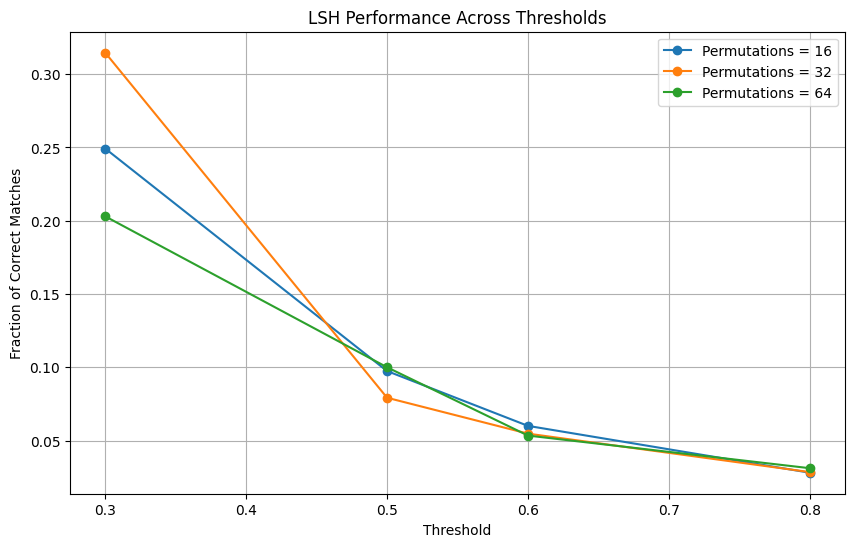

In [ ]:
# plot LSH performance vs. threshold for all ppermutations
fig, ax = plt.subplots(figsize=(10, 6))  # figure size

for perm in permutations:
  x = thresholds[::-1]
  y = [r['correct_fraction'] for r in results if r['permutations'] == perm]
  ax.plot(x, y, marker='o', label=f"Permutations = {perm}")

ax.set_title("LSH Performance Across Thresholds")
ax.set_xlabel("Threshold")
ax.set_ylabel("Fraction of Correct Matches")
ax.legend()
plt.grid(True)
plt.show()

The plot shows the LSH performance (fraction of correct matches) across varying thresholds for different numbers of permutations $(16, 32, 64)$. As the threshold decreases, the fraction of correct matches increases for all permutations, indicating that lower thresholds allow more candidate neighbors to be retrieved, improving accuracy. Additionally, higher permutations $(e.g. 32, 64)$ generally provide more accurate results compared to lower permutations $(16)$, as they improve MinHash representation. However, the overall fraction remains relatively low, reflecting the challenges of achieving high similarity detection in this dataset.

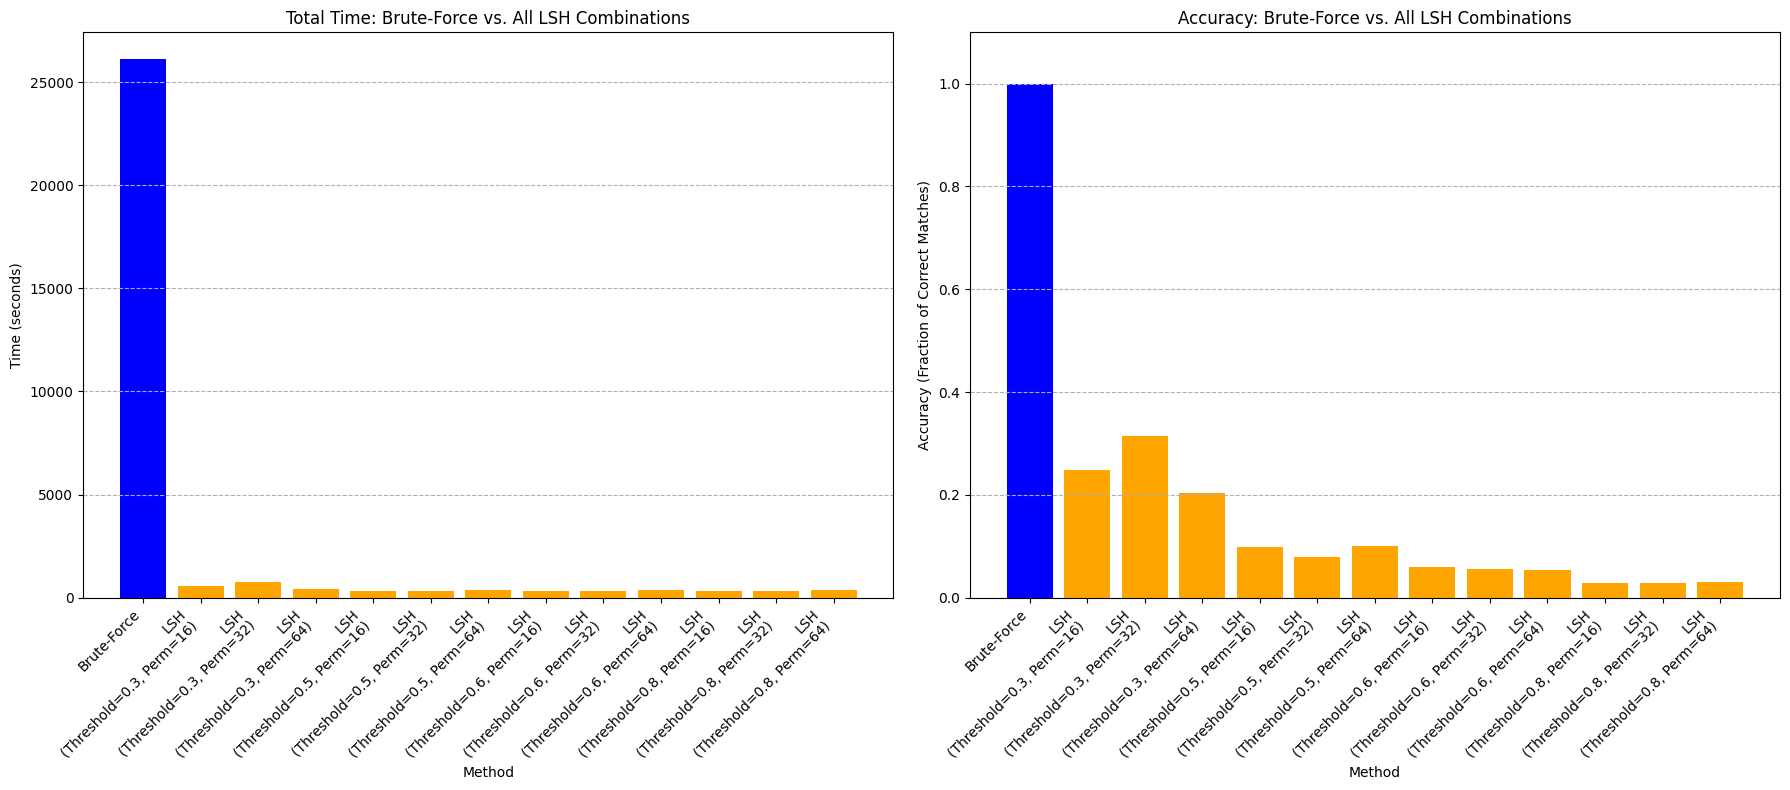

In [ ]:
brute_force_accuracy = 1.0  # brute-force is always 100% accurate

# prepare data for plotting
methods = []
times = []
accuracies = []

# add all combinations of thresholds and permutations to the methods, times, and accuracies lists
for threshold in thresholds:
  for perm in permutations:
    matching_result = next((r for r in results if r['threshold'] == threshold and r['permutations'] == perm), None)
    if matching_result:
      methods.append(f"LSH\n(Threshold={threshold}, Perm={perm})")
      times.append(matching_result['total_time'])
      accuracies.append(matching_result['correct_fraction'])

# add brute force baseline
methods.insert(0, "Brute-Force")
times.insert(0, brute_force_time)
accuracies.insert(0, brute_force_accuracy)

# create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # 1 row, 2 columns

# plot total times in the first subplot
axes[0].bar(methods, times, color=['blue'] + ['orange'] * len(results))
axes[0].set_title("Total Time: Brute-Force vs. All LSH Combinations")
axes[0].set_ylabel("Time (seconds)")
axes[0].set_xlabel("Method")
axes[0].grid(axis='y', linestyle='--')
axes[0].set_xticks(range(len(methods)))
axes[0].set_xticklabels(methods, rotation=45, ha='right')  # rotate x-axis labels

# plot accuracies in the second subplot
axes[1].bar(methods, accuracies, color=['blue'] + ['orange'] * len(results))
axes[1].set_title("Accuracy: Brute-Force vs. All LSH Combinations")
axes[1].set_ylabel("Accuracy (Fraction of Correct Matches)")
axes[1].set_xlabel("Method")
axes[1].grid(axis='y', linestyle='--')
axes[1].set_ylim(0, 1.1)
axes[1].set_xticks(range(len(methods)))
axes[1].set_xticklabels(methods, rotation=45, ha='right')  # rotate x-axis labels

# display the plots
plt.tight_layout()
plt.show()

In the above graph, we see the total computation time and accuracy (fraction of correct matches) for the brute-force method compared to all LSH combinations across different thresholds and permutations. Brute-force exhibits significantly higher computation time but achieves perfect accuracy, while LSH demonstrates much lower computation times with varying accuracy. The results highlight the trade-off in LSH between computation time and accuracy, where lower thresholds and higher permutations tend to improve accuracy but come at an increased computational cost.

As a final experiment, we had hoped to explore higher permutation values (256 and 512). However, due to limited computational resources, we are unable to carry out this experiment at this time. Increasing the number of permutations involves generating longer signature vectors, which provide a more detailed representation of the data points and are expected to improve the accuracy of similarity matching.

While this goes beyond the scope of the original question and aligns with the exhaustive, resource-intensive experiments conducted earlier, we believe that increasing the number of permutations would lead to better performance. Longer signature vectors reduce the probability of collisions (i.e., dissimilar points being incorrectly represented as similar), allowing the LSH method to more accurately distinguish between similar and dissimilar data points. This refined representation is likely to enhance the alignment of the LSH method with the results of the brute-force k-NN approach.